In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import multivariate_normal

In [5]:
def covariance(sigma1=1., sigma2=1., theta=0.):
    """
        Covariance matrix with eigenvalues sigma1 and sigma2, rotated by the angle theta.
    """
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    cov = np.array([[sigma1, 0.],
                   [0, sigma2]])
    return rotation.dot(cov.dot(rotation.T))

In [6]:
from scipy.stats import multivariate_normal

def gaussian_sample(mu=[0, 0], sigma1=1., sigma2=1., theta=0., n=50):
    cov = covariance(sigma1, sigma2, theta)
    x = multivariate_normal.rvs(mean=mu, cov=cov, size=n)
    return x

X = gaussian_sample(sigma1=1, sigma2=10, n=500)

print("Mean:", X.mean(axis=0))
print("Covariance:", np.cov(X.T))



Mean: [ 0.06506267 -0.12256407]
Covariance: [[  9.83594420e-01   7.33916365e-03]
 [  7.33916365e-03   1.08405470e+01]]


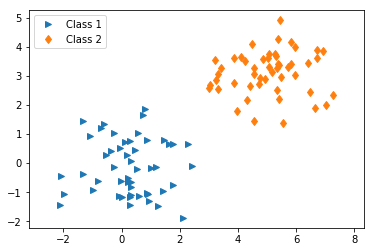

In [13]:
def plotXY(X, Y):
    if X.shape == Y.shape:
        X1 = X
        X2 = Y
    else:
        X1 = X[Y == Y.max()]
        X2 = X[Y == Y.min()]
    plt.plot(X1[:, 0], X1[:, 1], ">", label="Class 1")
    plt.plot(X2[:, 0], X2[:, 1], "d", label="Class 2")
    plt.axis('equal')

    
X1 = gaussian_sample(mu=[0, 0])
X2 = gaussian_sample(mu=[5, 3])


plotXY(X1, X2)
plt.legend(loc="best");

In [14]:
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearClassifierMixin
class LDA(BaseEstimator, LinearClassifierMixin):
    """
        LDA classifier for two classes.
    """
    def __init__(self, prior=None):
        """
            prior: wether to use prior in the intercept. Default is false.
        """
        self.prior = prior
        
    def fit(self, X, y):
        cov = np.cov(X.T, bias=2)  # Covariance matrix
        invcov = np.linalg.inv(cov)  # Inverse covariance matrix
        mu1 = X[y==y.max(), :].mean(axis=0)
        mu2 = X[y==y.min(), :].mean(axis=0)
        if not self.prior:
            pi1, pi2 = 0.5, 0.5
        else:
            pi1, pi2 = np.mean(y == y.max()), np.mean(y == y.min())
        self.coef_ = invcov.dot(mu1-mu2)
        self.intercept_ = 0.5*(mu2.dot(invcov.dot(mu2)) - mu1.dot(invcov.dot(mu1))) + \
            np.log(pi1/pi2)
        return self

    def decision_function(self, X):
        return X.dot(self.coef_) + self.intercept_

    def predict(self, X):
        return (self.decision_function(X) > 0)*2 - 1

In [48]:
def plot_frontiere(clf, data=None, num=200, label=None):
    """
        Plot the frontiere f(x)=0 of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: binary classifier with a method decision_function
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = np.fabs(clf.decision_function(np.c_[x.ravel(), y.ravel()])).reshape(x.shape)
    zmin, zmax = z.min(), z.max()
    ind = np.where((z-zmin)/(zmax-zmin) < 0.001)
    plt.plot(x[ind], y[ind], label=label)

LDA parameters:
[-0.8189399  -0.57387929] 2.81541943955


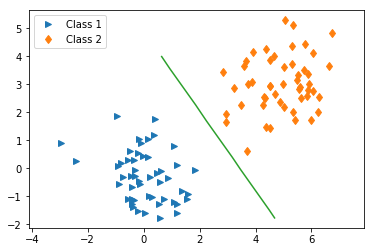

In [59]:
X = np.r_[X1, X2]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]

lda = LDA()
lda.fit(X, Y)
print("LDA parameters:")
print(lda.coef_ / np.linalg.norm(lda.coef_), lda.intercept_ / np.linalg.norm(lda.coef_))

plotXY(X, Y)
plot_frontiere(lda, X)
plt.legend(loc="best")